# ==========================================================
# Medical Image Enhancement GAN (CPU Optimized, RGB)
# Dataset: Kvasir-SEG via KaggleHub
# Author: Deepak Burathoki
# ==========================================================

In [ ]:
import os, random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

# ==========================================================
# 1. Download Dataset
# ==========================================================

In [ ]:
path = kagglehub.dataset_download("debeshjha1/kvasirseg")
print("✅ Dataset downloaded at:", path)

base_dir = os.path.join(path, "Kvasir-SEG")
image_dir = base_dir

IMG_SIZE = 256
BATCH_SIZE = 4


Using Colab cache for faster access to the 'kvasirseg' dataset.
✅ Dataset downloaded at: /kaggle/input/kvasirseg


# ==========================================================
# 2. ImageDataGenerator for Loading RGB Images
# ==========================================================

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='rgb',      # ensure RGB
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='rgb',      # ensure RGB
    subset='validation',
    shuffle=False
)

Found 2400 images belonging to 1 classes.
Found 600 images belonging to 1 classes.


# ==========================================================
# 3. Low-Res / High-Res Pair Generator (RGB preserved)
# ==========================================================

In [ ]:
def pair_generator(gen):
    for batch in gen:
        high_res = tf.convert_to_tensor(batch, dtype=tf.float32)
        # Low-res -> upscaled back to original size
        low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
        low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])
        yield low_res, high_res

train_dataset = tf.data.Dataset.from_generator(
    lambda: pair_generator(train_gen),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: pair_generator(val_gen),
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset ready.")

✅ Dataset ready.


# ==========================================================
# 4. Generator (U-Net)
# ==========================================================

In [ ]:
def build_generator():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    e1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs); e1 = layers.LeakyReLU(0.2)(e1)
    e2 = layers.Conv2D(128, 4, strides=2, padding='same')(e1); e2 = layers.BatchNormalization()(e2); e2 = layers.LeakyReLU(0.2)(e2)
    e3 = layers.Conv2D(256, 4, strides=2, padding='same')(e2); e3 = layers.BatchNormalization()(e3); e3 = layers.LeakyReLU(0.2)(e3)
    b  = layers.Conv2D(512, 4, strides=2, padding='same')(e3); b  = layers.ReLU()(b)
    d1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(b); d1 = layers.BatchNormalization()(d1); d1 = layers.ReLU()(d1); d1 = layers.Concatenate()([d1, e3])
    d2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d1); d2 = layers.BatchNormalization()(d2); d2 = layers.ReLU()(d2); d2 = layers.Concatenate()([d2, e2])
    d3 = layers.Conv2DTranspose(64,  4, strides=2, padding='same')(d2); d3 = layers.BatchNormalization()(d3); d3 = layers.ReLU()(d3); d3 = layers.Concatenate()([d3, e1])
    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(d3)
    return Model(inputs, outputs, name="Generator")


# ==========================================================
# 5. Discriminator (PatchGAN)
# ==========================================================

In [ ]:
def build_discriminator():
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    tar = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Concatenate()([inp, tar])
    x = layers.Conv2D(64, 4, strides=2, padding='same')(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128,4,strides=2,padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256,4,strides=2,padding='same')(x); x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1,4,padding='same')(x)
    return Model([inp, tar], x, name="Discriminator")

# ==========================================================
# 6. Losses & Optimizers
# ==========================================================

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gen_loss(disc_gen, gen_out, target):
    adv = bce(tf.ones_like(disc_gen), disc_gen)
    l1  = tf.reduce_mean(tf.abs(target - gen_out))
    return adv + 100*l1

def disc_loss(disc_real, disc_gen):
    real = bce(tf.ones_like(disc_real), disc_real)
    fake = bce(tf.zeros_like(disc_gen), disc_gen)
    return real + fake

generator     = build_generator()
discriminator = build_discriminator()
g_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# ==========================================================
# 7. Train Step
# ==========================================================

In [ ]:
@tf.function
def train_step(inp, tar):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        gen_out = generator(inp, training=True)
        disc_real = discriminator([inp, tar], training=True)
        disc_gen  = discriminator([inp, gen_out], training=True)
        g_loss = gen_loss(disc_gen, gen_out, tar)
        d_loss = disc_loss(disc_real, disc_gen)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return g_loss, d_loss

# ==========================================================
# 8. Training Loop (Finite Steps)
# ==========================================================

In [ ]:
steps_per_epoch = train_gen.n // BATCH_SIZE
EPOCHS = 10  # increase for real training

for ep in range(EPOCHS):
    print(f"\nEpoch {ep+1}/{EPOCHS}")
    for i, (inp, tar) in enumerate(train_dataset.take(steps_per_epoch)):
        g_loss, d_loss = train_step(inp, tar)
        if i % 20 == 0:
            print(f"Step {i}: G={g_loss:.4f} D={d_loss:.4f}")
print("✅ Training Complete.")


Epoch 1/10
Step 0: G=6.8780 D=0.0481
Step 20: G=4.8039 D=0.1292
Step 40: G=2.2002 D=1.0629
Step 60: G=4.2389 D=0.1795
Step 80: G=7.3939 D=0.1386
Step 100: G=2.8653 D=0.9184
Step 120: G=3.5578 D=0.3495
Step 140: G=4.0877 D=0.1857
Step 160: G=6.5778 D=0.0569
Step 180: G=6.8334 D=0.0785
Step 200: G=6.3819 D=0.1730
Step 220: G=6.0055 D=0.0536
Step 240: G=4.0883 D=0.5378
Step 260: G=7.9594 D=0.0926
Step 280: G=5.6316 D=1.7758
Step 300: G=4.5669 D=0.0721
Step 320: G=6.3163 D=0.2657
Step 340: G=2.4920 D=2.0138
Step 360: G=5.1611 D=0.0884
Step 380: G=6.7007 D=0.1949
Step 400: G=6.1804 D=0.0814
Step 420: G=2.4887 D=0.5453
Step 440: G=1.8375 D=1.1086
Step 460: G=4.6940 D=0.3201
Step 480: G=11.0205 D=1.1534
Step 500: G=5.6527 D=0.1607
Step 520: G=6.2378 D=0.0302
Step 540: G=6.8042 D=0.0666
Step 560: G=7.3937 D=0.0304
Step 580: G=7.4979 D=0.0255

Epoch 2/10
Step 0: G=8.0859 D=1.0242
Step 20: G=5.3036 D=0.1580
Step 40: G=6.1471 D=0.0806
Step 60: G=1.6625 D=1.7202
Step 80: G=2.2288 D=1.4566
Step 10

# ==========================================================
# 9. PSNR & SSIM Evaluation
# ==========================================================

In [ ]:
def evaluate_quality(true, pred):
    psnr = tf.image.psnr(true, pred, max_val=1.0)
    ssim = tf.image.ssim(true, pred, max_val=1.0)
    return float(tf.reduce_mean(psnr)), float(tf.reduce_mean(ssim))

# ==========================================================
# 10. Test & Visualize Random Image
# ==========================================================

In [ ]:
def test_random_image():
    i = random.randint(0, train_gen.n-1)
    batch_idx = i // BATCH_SIZE
    idx_in_batch = i % BATCH_SIZE
    batch = train_gen[batch_idx]

    # Original RGB image
    high_res = tf.convert_to_tensor(batch[idx_in_batch], dtype=tf.float32)

    # Low-res input
    low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
    low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])

    # Enhanced output
    enhanced = generator(tf.expand_dims(low_res, 0), training=False)[0]
    enhanced_img = tf.clip_by_value(enhanced, 0.0, 1.0)

    # Convert tensors to NumPy
    high_res_np = high_res.numpy()
    low_res_np = low_res.numpy()
    enhanced_np = enhanced_img.numpy()

    psnr, ssim = evaluate_quality(high_res, enhanced_img)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original High-Res")
    plt.imshow(high_res_np, cmap=None)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Low-Res Input")
    plt.imshow(low_res_np, cmap=None)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f"Enhanced Output\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
    plt.imshow(enhanced_np, cmap=None)
    plt.axis('off')

    plt.show()

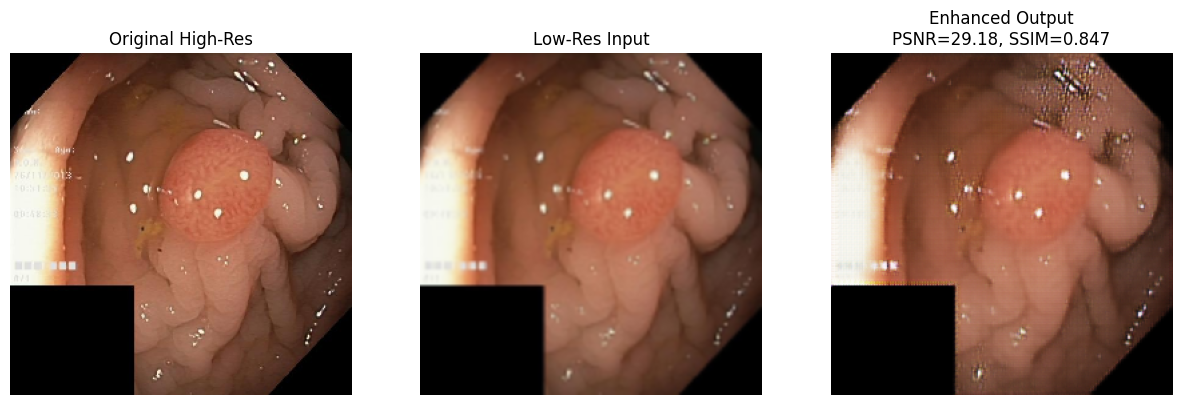

In [ ]:
test_random_image()

# ==========================================================
# 11. Batch Enhancement + Metrics Logging (RGB-safe)
# ==========================================================

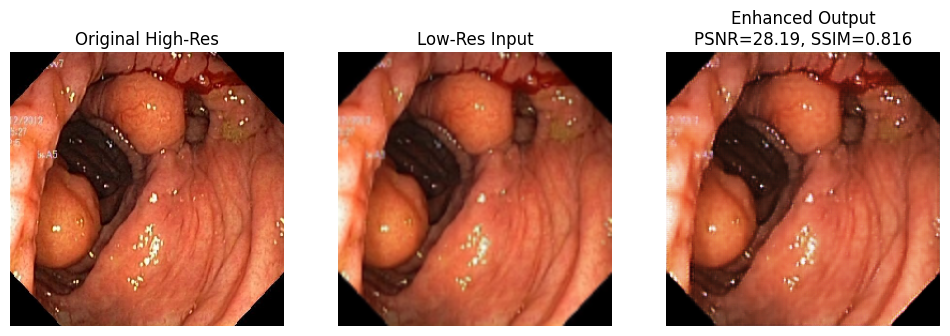

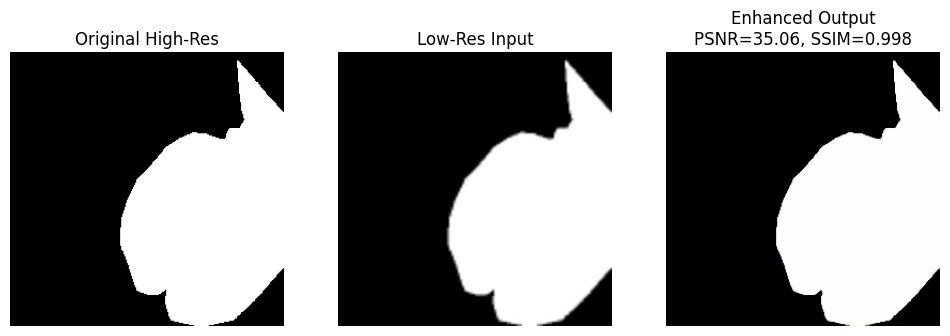

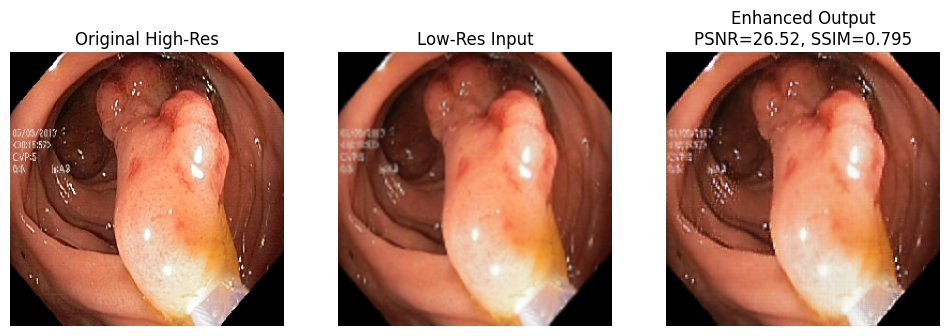

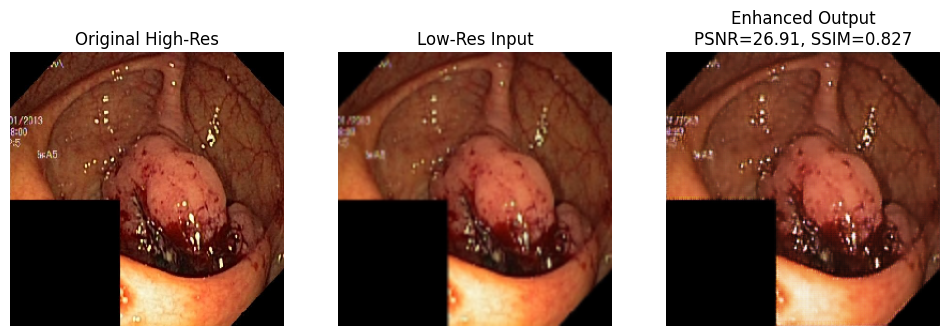

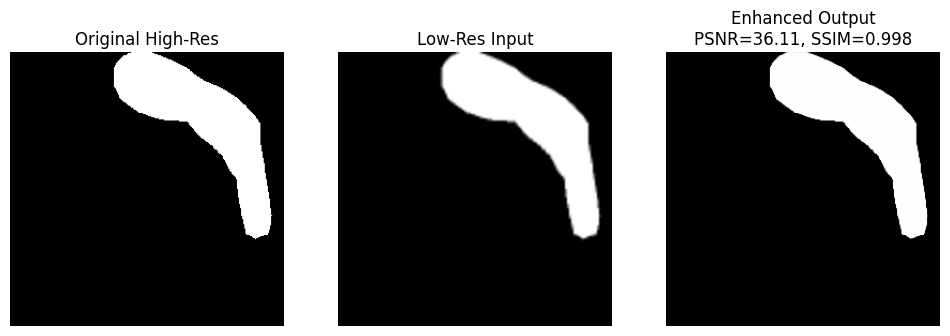

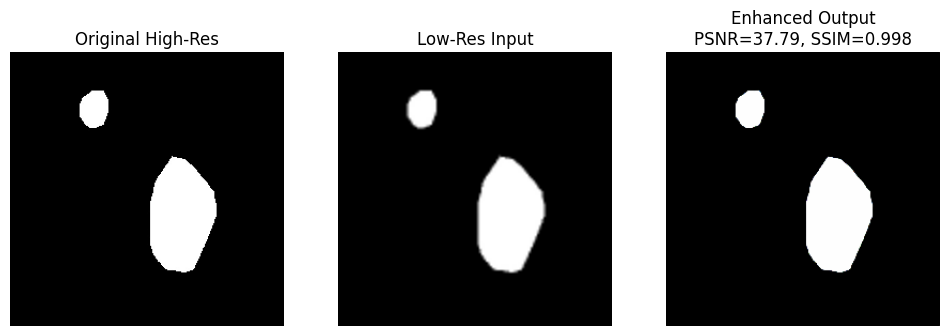

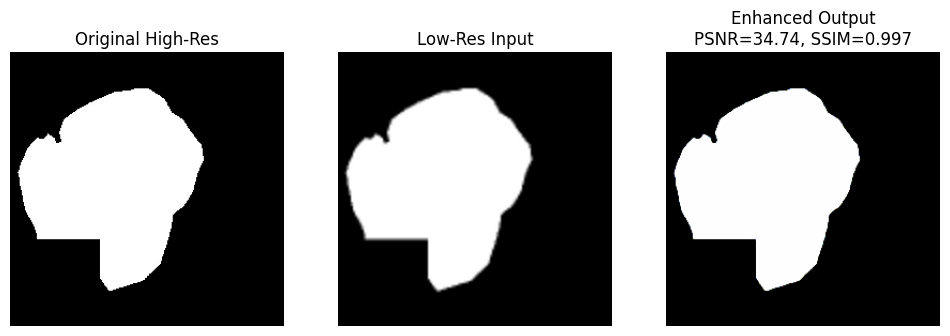

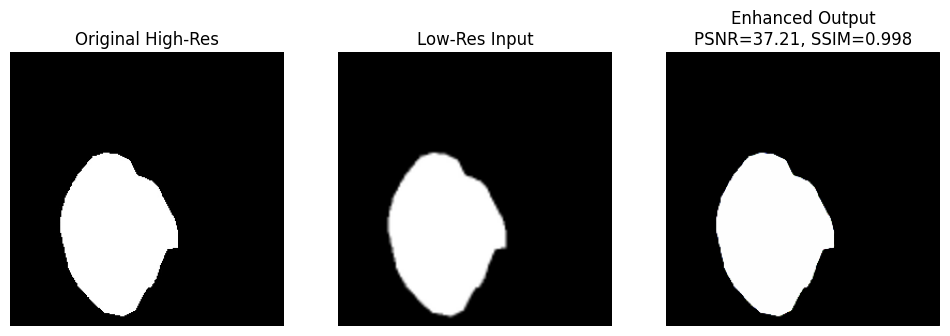

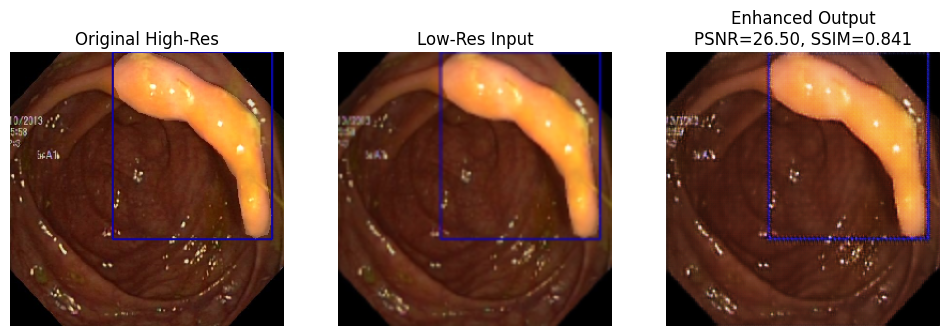

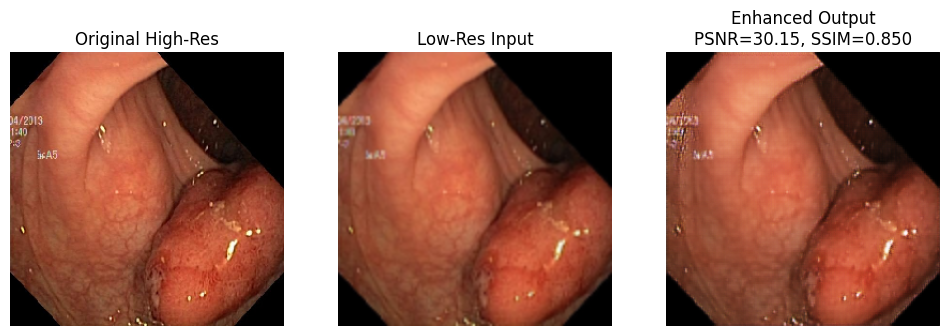

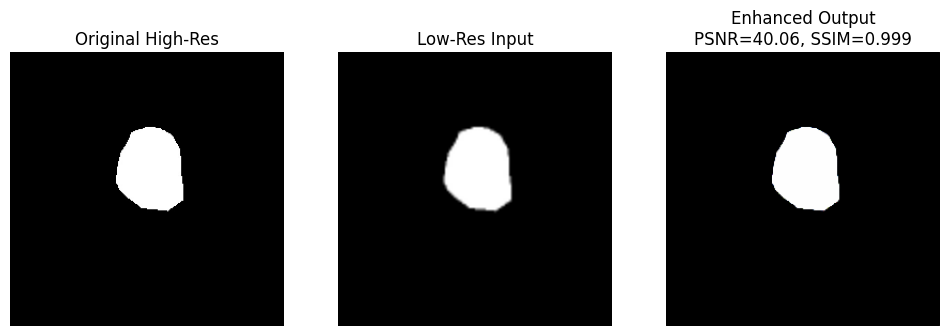

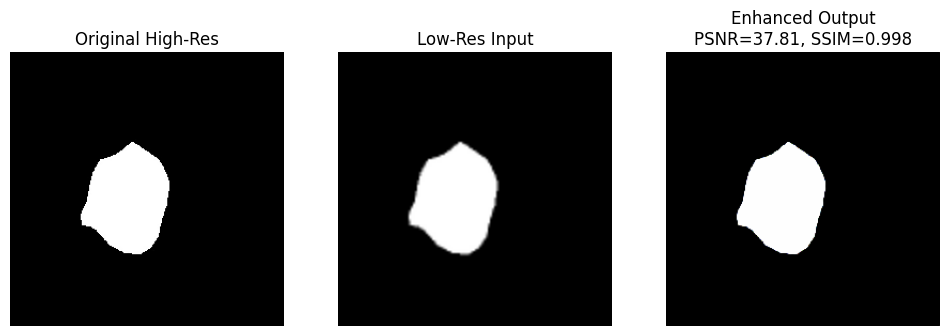

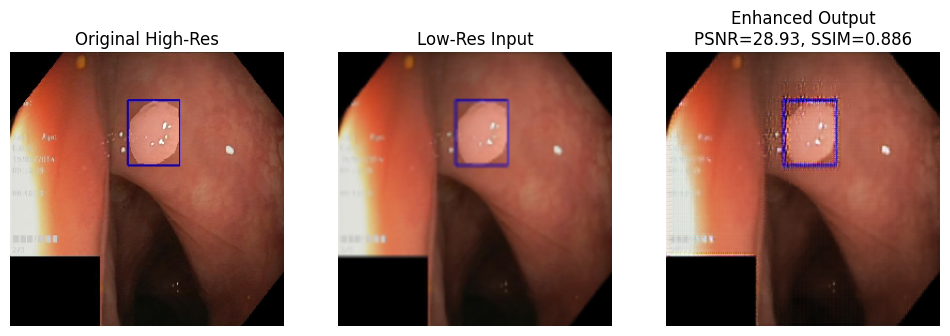

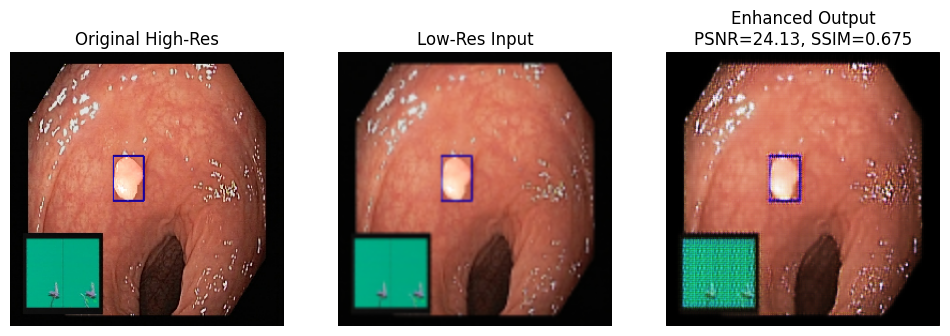

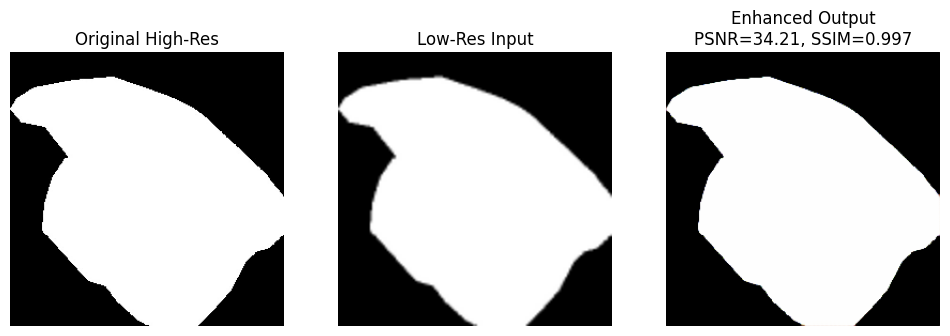

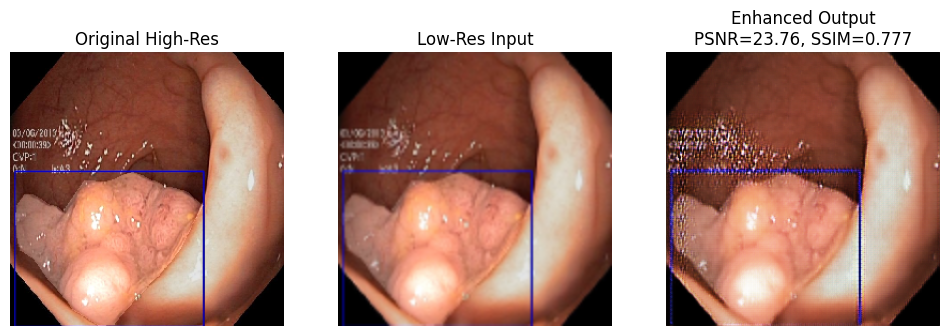

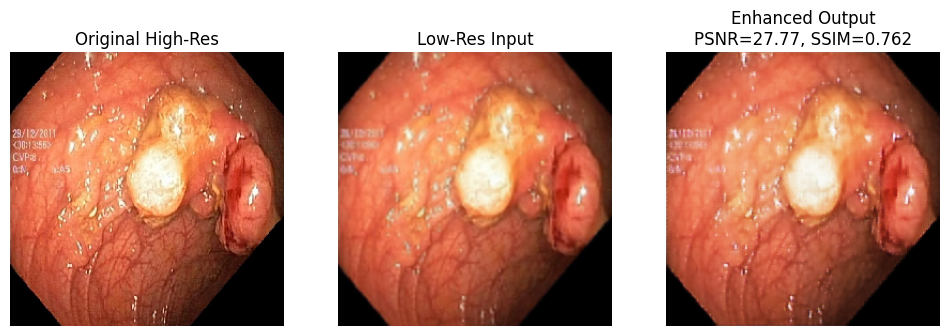

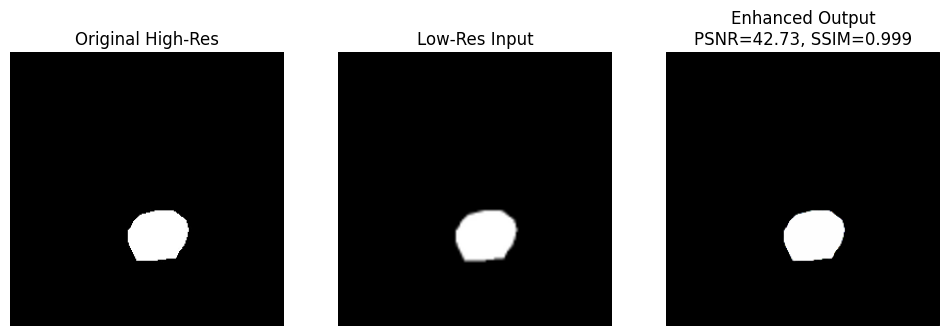

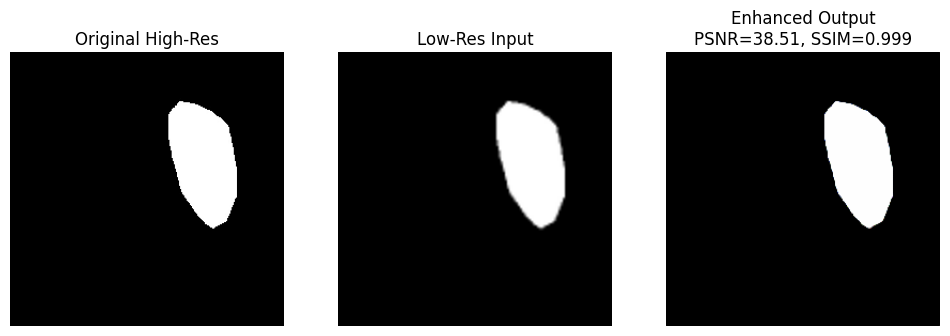

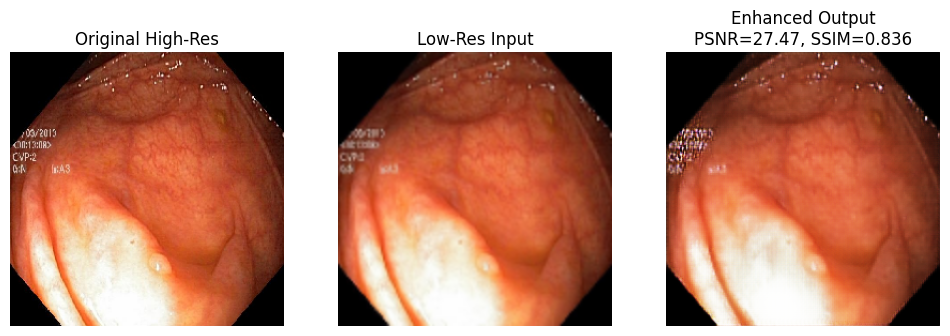

✅ Enhanced images saved at 'enhanced_results' with PSNR/SSIM metrics.


In [ ]:
output_dir = "enhanced_results"
os.makedirs(output_dir, exist_ok=True)
metrics = []

num_demo_images = min(train_gen.n, 20)  # first 20 images for demo

for i in range(num_demo_images):
    # Determine batch and index within batch
    batch_idx = i // BATCH_SIZE
    idx_in_batch = i % BATCH_SIZE
    batch = train_gen[batch_idx]

    # Original high-res image (RGB)
    high_res = tf.convert_to_tensor(batch[idx_in_batch], dtype=tf.float32)

    # Low-res version for generator input
    low_res = tf.image.resize(high_res, [IMG_SIZE//2, IMG_SIZE//2])
    low_res = tf.image.resize(low_res, [IMG_SIZE, IMG_SIZE])

    # Enhance using generator
    enhanced = generator(tf.expand_dims(low_res, 0), training=False)[0]
    enhanced_img = tf.clip_by_value(enhanced, 0.0, 1.0)

    # Save enhanced image with RGB preserved
    out_path = os.path.join(output_dir, f"enhanced_{i}.png")
    plt.imsave(out_path, enhanced_img.numpy(), format='png')  # RGB preserved

    # Compute metrics
    psnr, ssim = evaluate_quality(high_res, enhanced_img)
    metrics.append([f"img_{i}", psnr, ssim])

    # Optional: show images in a row
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original High-Res")
    plt.imshow(high_res)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Low-Res Input")
    plt.imshow(low_res)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title(f"Enhanced Output\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
    plt.imshow(enhanced_img)
    plt.axis('off')

    plt.show()

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics, columns=["Image", "PSNR", "SSIM"])
metrics_df.to_csv(os.path.join(output_dir, "metrics.csv"), index=False)
print(f"✅ Enhanced images saved at '{output_dir}' with PSNR/SSIM metrics.")
